# Features

In [1]:
from datasets import load_dataset

train_data = load_dataset("imdb", split="train")

Found cached dataset imdb (C:/Users/DELL/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


In [2]:
from string import punctuation
import re


def preprocess(dataset: dict) -> dict:
    """
    Define a function to preprocess the text
    """
    # convert the text to lowercase and remove <br>
    dataset['text'] = dataset['text'].lower().replace('<br /><br />', '')
    
    # replace punctuation with spaces
    new_punc = punctuation.replace('!', '')
    dataset['text'] = re.sub('['+new_punc+']', ' ', dataset['text'])
    
    # Replace multiple with a single space
    dataset['text'] = " ".join(dataset['text'].split())
    
    return dataset

# Apply the preprocessing function to the dataset
train_data = train_data.map(preprocess)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [4]:
from math import log
import numpy as np


def get_lexicon_list() -> tuple:
    """
    A function to create the list of positive and negative words from the vader lexicon
    """
    
    with open("./vader_lexicon.txt") as file:
        lines = file.read().splitlines()

    lexicon = {}
    for line in lines:
        splits = line.split("\t")
        lexicon[splits[0]] = float(splits[1])

    positive_lexicon = {}
    negative_lexicon = {}

    for word, score in lexicon.items():
        if score >= 1:
            positive_lexicon[word] = score
        if score <= -1:
            negative_lexicon[word] = score
    return positive_lexicon, negative_lexicon


def get_words_sentiment(tokens: list) -> tuple:
    """ 
    A function that take a list of words and return the number of positive and negative words.
    """
    positive_lexicon, negative_lexicon = get_lexicon_list()
    pos_count = 0
    neg_count = 0

    for word in tokens:
        if word in positive_lexicon:
            pos_count += 1
        if word in negative_lexicon:
            neg_count += 1
    return pos_count, neg_count


def features(text: str) -> list:
    """
    A function to generate a vector with the features described in the subject.
    """
    
    tokens = text.split(" ")
    neg = 1 if "no" in tokens else 0
    pronouns = tokens.count("i") + tokens.count("you")
    exclamation = 1 if "!" in text else 0
    log_count = log(len(tokens))
    positive_words, negative_words = get_words_sentiment(tokens)
    return [neg, pronouns, exclamation, log_count, positive_words, negative_words]


def get_array(dataset: dict) -> np.ndarray:
    """
    Apply the feature function to all the dataset.
    """
    return np.array([features(text) for text in dataset])


In [5]:
# Let's test it with the example used in class
text = "i love this good movie !"
features(text)

[0, 1, 1, 1.791759469228055, 2, 0]

We get the same result : [0, 1, 1, 1.791759469228055, 2, 0]

# Logistic regression classifier

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

import torch
from torch import nn

In [7]:
# Apply the feature function to all the dataset
all_points = get_array(train_data["text"])
labels = train_data["label"]

In [8]:
# Creation of the dataframe
df = pd.DataFrame()
names = ["neg", "pronouns", "exclamation", "log_count", "positive_words", "negative_words"]

for idx, name in enumerate(names):
    df[name] = all_points[:, idx]
df["label"] = labels
df.head()

,neg,pronouns,exclamation,log_count,positive_words,negative_words,label
0,1.0,7.0,0.0,5.673323,10.0,6.0,0
1,1.0,3.0,0.0,5.429346,6.0,4.0,0
2,1.0,0.0,0.0,4.510860,3.0,3.0,0
3,0.0,3.0,0.0,4.795791,5.0,5.0,0
4,0.0,10.0,1.0,5.730100,5.0,11.0,0


In [9]:
# We split the training set into training and validation set

all_points = torch.tensor(all_points, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.float32).reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(
    all_points,
    labels,
    test_size=0.2,
    stratify=labels,
    random_state=42,
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=42,
)

In [10]:
class LogisticRegression(nn.Module):
    """A logistic regression implementation"""

    def __init__(self, input_dim: int, nb_classes: int) -> None:
        """
        Args:
            input_dim: the dimension of the input features.
            nb_classes: the number of classes to predict.
        """
        super().__init__()
        output_layer = nn.Sigmoid() if nb_classes == 1 else nn.Softmax()
        self.classifier = torch.nn.Sequential(
            nn.Linear(input_dim, nb_classes),
            output_layer,
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: the input tensor.
        Returns:
            The output of activation function.
        """
        return self.classifier(x)

In [11]:
model = LogisticRegression(6, 1)

In [12]:
%%time

# Keeping an eye on the losses
train_losses = []
test_losses = []

def training_loop(train_losses: list, test_losses: list, weight: int = 0.5) -> tuple:
    """ Take the weight_decay in argument and apply a SGD with it """
    criterion = nn.BCELoss()  # Binary cross entropy
    # Stochastic gradient descent
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=weight)
    
    n_epochs = 1000

    # Training loop
    for epoch in range(n_epochs):
        # Setting all gradients to zero.
        optimizer.zero_grad()

        # Sending the whole training set through the model.
        predictions = model(X_train)
        # Computing the loss.
        loss = criterion(predictions, y_train)
        train_losses.append(loss.item())
        if epoch % 100 == 0:
            print(loss)
        # Computing the gradients and gradient descent.
        loss.backward()
        optimizer.step()

        # When computing the validation loss, we do not want to update the weights.
        # torch.no_grad tells PyTorch to not save the necessary data used for
        # gradient descent.
        with torch.no_grad():
            predictions = model(X_valid)
            loss = criterion(predictions, y_valid)
            test_losses.append(loss)
    return train_losses, test_losses
            
train_losses, test_losses = training_loop(train_losses, test_losses)

tensor(2.2879, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5869, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5838, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5828, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5823, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5821, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5819, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5818, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5818, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5818, grad_fn=<BinaryCrossEntropyBackward0>)
CPU times: total: 2.31 s
Wall time: 1.73 s


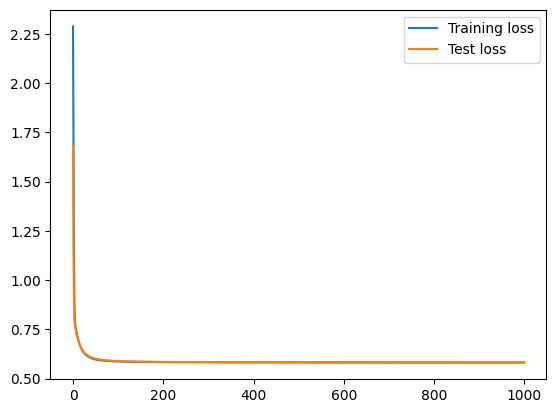

In [13]:
# Checking the losses
plt.plot(np.arange(len(train_losses)), train_losses, label="Training loss")
plt.plot(np.arange(len(test_losses)), test_losses, label="Test loss")
plt.legend()

In [14]:
# Computing the accuracy for our 3 splits.
with torch.no_grad():
    p_train = model(X_train)
    p_train = np.round(p_train.numpy())
    training_accuracy = np.mean(p_train == y_train.numpy())
    p_valid = model(X_valid)
    p_valid = np.round(p_valid.numpy())
    valid_accuracy = np.mean(p_valid == y_valid.numpy())
    p_test = model(X_test)
    p_test = np.round(p_test.numpy())
    test_accuracy = np.mean(p_test == y_test.numpy())
print(training_accuracy, valid_accuracy, test_accuracy)

0.7153125 0.71275 0.7014


### The result of the accuracy of our 3 splits :
- Training accuracy : 0.7153125 
- Validation accuracy : 0.71275 
- Test accuracy : 0.7014

# Which features seems to play most for both classes ?

In [15]:
model.classifier[0].state_dict()["weight"], model.classifier[0].state_dict()["bias"]

(tensor([[-0.0262, -0.0492, -0.0055, -0.0145,  0.1286, -0.1506]]),
 tensor([-0.0041]))

### We get the following result :
(tensor([[-0.0262, -0.0492, -0.0055, -0.0145,  0.1286, -0.1506]]),
 tensor([-0.0041]))
 
The two features (5 and 6) that seem to play the most for both classes are the number of words in the documents that are either in the positive or negative lexicons.

# Bonus
##  weight_decay variation

In [16]:
def weight_variation(weight_list: list):
    """ Take a list of weight_decays and apply the SGD on each element of the list """
    train_losses, test_losses = [], []
    for weight in weight_list:
        train_losses, test_losses = training_loop(train_losses, test_losses, weight)
        print(f"Weight : {weight}", model.classifier[0].state_dict()["weight"], "Bias : ", model.classifier[0].state_dict()["bias"])
        

weight_list = [0.01, 0.1, 2, 5, 10]

weight_variation(weight_list)

tensor(0.5817, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5798, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5796, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5795, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5794, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5793, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5793, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5792, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5791, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5790, grad_fn=<BinaryCrossEntropyBackward0>)
Weight : 0.01 tensor([[-0.1177, -0.0595, -0.0217, -0.0164,  0.1516, -0.1733]]) Bias :  tensor([-0.0072])
tensor(0.5790, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5791, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5791, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5791, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5792, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5792, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5792, grad_fn=<BinaryC

## We use a list of 5 weight_decays and get the following result :

- Weight_decay : 0.01  --> tensor([[-0.1177, -0.0595, -0.0217, -0.0164,  0.1516, -0.1733]]) Bias :  tensor([-0.0072])
- Weight_decay : 0.1 --> tensor([[-0.1012, -0.0572, -0.0185, -0.0157,  0.1464, -0.1682]]) Bias :  tensor([-0.0065])
- Weight_decay : 2 --> tensor([[-0.0097, -0.0327, -0.0020, -0.0088,  0.0928, -0.1109]]) Bias :  tensor([-0.0018])
- Weight_decay : 5 --> tensor([[-0.0049, -0.0202, -0.0010, -0.0049,  0.0632, -0.0764]]) Bias :  tensor([-0.0010])
- Weight_decay : 10 --> tensor([[-0.0028, -0.0125, -0.0006, -0.0028,  0.0428, -0.0518]]) Bias :  tensor([-0.0005])

With low values of the parameter weight_decay, the word 'no'(feature 1) has the most influence on both classes.
While the value of the weight_decay is increasing, the influence tends to decrease in favor of the weights positive and negative words (feature 5 and 6). 

# Analysis of two failed predictions

In [18]:
# Look for failed predictions
failed_predictions = ((p_test == y_test.numpy()) == False).nonzero()
two_wrong = list(failed_predictions[0][:2]) # We choose two wrong predictions

df.iloc[two_wrong]

,neg,pronouns,exclamation,log_count,positive_words,negative_words,label
1,1.0,3.0,0.0,5.429346,6.0,4.0,0
9,1.0,5.0,0.0,5.446737,10.0,9.0,0


We can explain the failure of the model by the fact that the 2 most important features which are the number of positive and negative words in the document have very close values.

# Bonus

In [19]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0).fit(X_train, np.ravel(y_train))
clf.score(X_test, y_test)

0.7042

### We get the following score as result : 0.7042

Using the scikit-learn implementation of logistic regression classifier, we can see there is no improvement in the accuracy score. We can then deduce that this is not an implementation problem but a problem of choice and representation of the differents features.